## Reddit Sentimental Analysis ModelCreation

Best KMeans Model with n_clusters=2 and num_topics=2
Silhouette Score: 0.8704070606168149
Clustered Data:
                                          cleaned_text  Cluster
0    discussion thread first u presidential general...        1
1    discussion thread first u presidential general...        1
2    megathread u supreme court rule trump claim im...        1
3    megathread mary peltola defeat sarah palin ala...        0
4    discussion thread u house speaker election day...        0
..                                                 ...      ...
203  chris christie possible presidential contender...        0
204  help understand write winner presidential elec...        0
205  united state decline however happening rather ...        0
206  california kamala harris becomes first indiana...        0
207  fox take trump healthcare statement donald tru...        0

[208 rows x 2 columns]


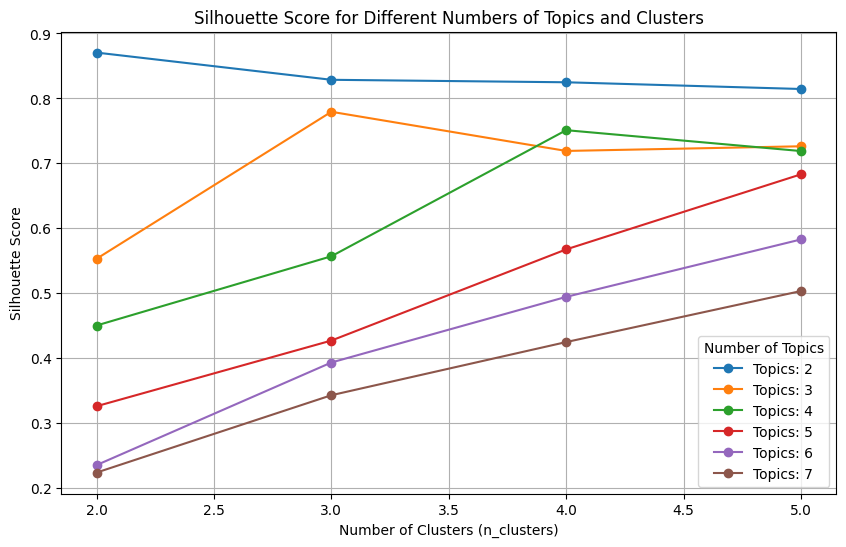

Silhouette Score for KMeans: 0.8704070606168149
Davies-Bouldin Index for KMeans: 0.1674420997413951
Cluster Distribution in Training Data: [131  77]

Examples from each cluster:

Cluster 0:
- megathread mary peltola defeat sarah palin alaska statewide special election u house representative democrat gained seat u house reprsentatives mary peltola dak defeated former governor alaska sarah palin rak final round rankedchoice vote peltola set become first alaska native represent state congress submission may interest submission domain peltola beat palin win alaska house special election apnewscom mary peltola democrat defeat sarah palin alaska special house election nytimescom mary peltola defeat sarah palin special election become first native american representing alaska congress nbc news project nbcnewscom democrat mary peltola defeat sarah palin become first native alaskan woman win congressional race independentcouk democrat peltola beat palin alaska special election upset politicocom

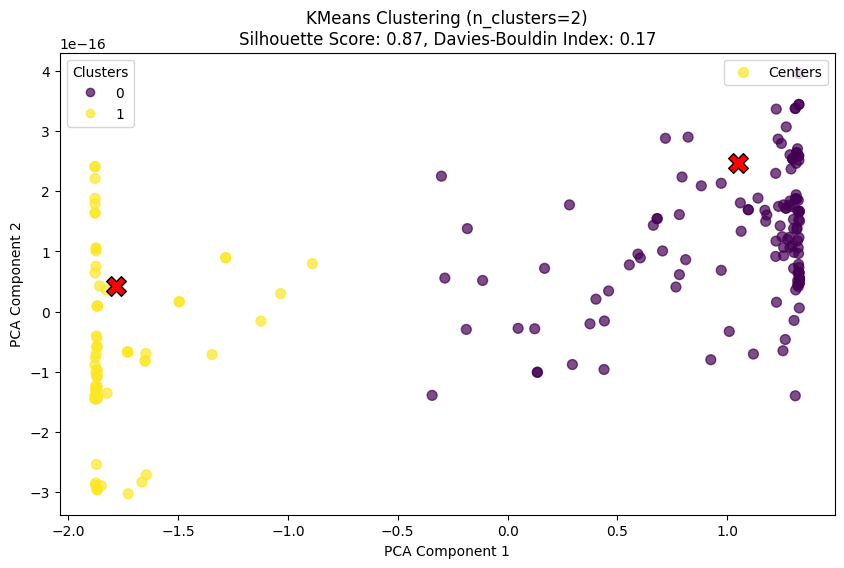

KMeans model saved as best_kmeans_model.h5
Vectorizer saved successfully!
LDA model saved successfully!
Scaler model saved successfully!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from joblib import dump

# Data paths
preprocessed_reddit_path = r".\clean_reddit_dataset.csv"

# Load the data
df = pd.read_csv(preprocessed_reddit_path)

# Initialize variables to track the best model and parameters
best_kmeans_score = -1
best_kmeans_model = None
best_kmeans_labels = None
best_n_clusters = 0
best_num_topics = 0
results = []  # Store results for plotting
best_vectorizer = None

for num_topics in range(2, 8):  # Adjust range as needed

    # Step 1: Preprocess text
    # CountVectorizer will handle tokenization, lowercase, and remove stop words
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(df['cleaned_text'])

    # Step 2: Apply LDA for Topic Modeling
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    topic_distributions = lda.fit_transform(X)

    # Step 3: Use Topic Distributions as Features for Clustering
    # Normalize topic distributions
    scaler = StandardScaler()
    topic_distributions_scaled = scaler.fit_transform(topic_distributions)

    # Test different values of k for KMeans
    for n_clusters in range(2, 6):  # Adjust range as needed
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans_labels = kmeans.fit_predict(topic_distributions_scaled)
        silhouette_avg = silhouette_score(topic_distributions_scaled, kmeans_labels)

        # Store the result for plotting
        results.append({
            'num_topics': num_topics,
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_avg
        })

        # Update best model if current silhouette score is the best
        if silhouette_avg > best_kmeans_score:
            best_kmeans_score = silhouette_avg
            best_kmeans_model = kmeans
            best_kmeans_labels = kmeans_labels
            best_n_clusters = n_clusters
            best_num_topics = num_topics
            best_topic_distributions_scaled = topic_distributions_scaled
            best_vectorizer = vectorizer
            best_lda = lda
            best_scaler = scaler

# Print the best KMeans model and its silhouette score
print(f"Best KMeans Model with n_clusters={best_n_clusters} and num_topics={best_num_topics}")
print(f"Silhouette Score: {best_kmeans_score}")

# Assign clusters to the original data
df['Cluster'] = best_kmeans_labels

# Display the clustered data
print("Clustered Data:")
print(df[['cleaned_text', 'Cluster']])

# Plot the silhouette scores for different configurations
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
for num_topics in results_df['num_topics'].unique():
    subset = results_df[results_df['num_topics'] == num_topics]
    plt.plot(subset['n_clusters'], subset['silhouette_score'], marker='o', label=f'Topics: {num_topics}')

plt.title("Silhouette Score for Different Numbers of Topics and Clusters")
plt.xlabel("Number of Clusters (n_clusters)")
plt.ylabel("Silhouette Score")
plt.legend(title="Number of Topics")
plt.grid(True)
plt.show()

# Step 3: Calculate Silhouette Score
silhouette_avg = silhouette_score(best_topic_distributions_scaled, best_kmeans_labels)
print(f"Silhouette Score for KMeans: {silhouette_avg}")

# Step 4: Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(best_topic_distributions_scaled, best_kmeans_labels)
print(f"Davies-Bouldin Index for KMeans: {davies_bouldin_avg}")

print(f"Cluster Distribution in Training Data: {np.bincount(best_kmeans_labels)}")

# Assign clusters to the original data
df['Cluster'] = best_kmeans_labels

# Display 10 examples from each cluster
print("\nExamples from each cluster:\n")
for cluster in range(best_n_clusters):
    print(f"Cluster {cluster}:")
    cluster_examples = df[df['Cluster'] == cluster].head(2)  # Get the first 2 examples from this cluster
    for i, row in cluster_examples.iterrows():
        print(f"- {row['cleaned_text']}")
    print("\n" + "-" * 50 + "\n")

# PCA for visualization
pca = PCA(n_components=2)
topic_distributions_pca = pca.fit_transform(best_topic_distributions_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(topic_distributions_pca[:, 0], topic_distributions_pca[:, 1],
                      c=best_kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.title(f"KMeans Clustering (n_clusters={best_n_clusters})\nSilhouette Score: {silhouette_avg:.2f}, Davies-Bouldin Index: {davies_bouldin_avg:.2f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Add cluster centers if available
centers_pca = pca.transform(best_kmeans_model.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, c='red', marker='X', edgecolor='k', label='Centers')

# Add legend for clusters
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)
plt.legend(['Centers'], loc='upper right')

plt.show()

# Save the best KMeans model to an .h5 file
dump(best_kmeans_model, './best_kmeans_model.h5')
# Save the trained vectorizer
dump(vectorizer, './vectorizer.pkl')
# Save the LDA model
dump(best_lda, './lda.pkl')
# Save the Scaler model
dump(best_scaler, './scaler.pkl')

print("KMeans model saved as best_kmeans_model.h5")
print("Vectorizer saved successfully!")
print("LDA model saved successfully!")
print("Scaler model saved successfully!")


# Clustering Reddit Posts: Topic Modeling and KMeans

This project clusters Reddit posts from a cleaned dataset using **Topic Modeling** and **KMeans Clustering**. Below is an explanation of the process and key results.

---

## **Process Overview**

### **1. Libraries and Data Loading**
- **Libraries Used:** 
  - `CountVectorizer` (for text processing)
  - `LatentDirichletAllocation` (for topic modeling)
  - `KMeans` (for clustering)
  - `silhouette_score` and `davies_bouldin_score` (for evaluation)
- **Dataset:** `clean_reddit_dataset.csv` containing cleaned Reddit posts in the column `cleaned_text`.

---

### **2. Key Steps**

1. **Text Preprocessing:**
   - Used `CountVectorizer` to tokenize, lowercase, and remove stop words, creating a document-term matrix.

2. **Topic Modeling with LDA:**
   - Extracted latent topics using **Latent Dirichlet Allocation (LDA)** for each `num_topics` (2 to 7).

3. **Feature Scaling:**
   - Normalized the topic distributions using `StandardScaler`.

4. **Clustering with KMeans:**
   - Tested **KMeans Clustering** for `n_clusters` ranging from 2 to 5 for each `num_topics`.

5. **Model Selection:**
   - Evaluated clustering quality using **Silhouette Score** and selected the best-performing model.

6. **Visualization:**
   - Plotted Silhouette Scores across configurations.
   - Reduced dimensions using **PCA** for 2D visualization of clusters.

7. **Evaluation Metrics:**
   - **Silhouette Score:** Measures how well-defined clusters are.
   - **Davies-Bouldin Index:** Lower values indicate better-defined clusters.

8. **Saving Models:**
   - Saved the best models (`KMeans`, `LDA`, `Vectorizer`, and `Scaler`) for reuse.

---

## **Key Results**

### **Best Model**
- **Number of Clusters:** 2
- **Number of Topics:** 2
- **Silhouette Score:** `0.8704` (indicating strong cluster separation).

### **Clustered Data**
- **Cluster 0:** Focuses on newsworthy election results and political developments.
- **Cluster 1:** Centers on discussions and debates related to elections.

### **Evaluation Metrics**
- **Silhouette Score:** `0.8704` (excellent clustering quality).
- **Davies-Bouldin Index:** `0.1674` (well-defined clusters).
- **Cluster Distribution:**
  - Cluster 0: 131 posts
  - Cluster 1: 77 posts

---

### **Examples from Clusters**
- **Cluster 0:** 
  - Posts discussing election outcomes (e.g., Mary Peltola vs. Sarah Palin).
- **Cluster 1:** 
  - Posts focused on debates (e.g., Biden vs. Trump).

---

## **Visualization**
1. **Silhouette Score Plot:** 
   - Displays Silhouette Scores for different `num_topics` and `n_clusters`.
2. **PCA Plot:**
   - Visualizes clusters in 2D space, with cluster centers highlighted.

---

## **Saved Outputs**
1. Best KMeans model: `best_kmeans_model.h5`
2. Vectorizer: `vectorizer.pkl`
3. LDA model: `lda.pkl`
4. Scaler: `scaler.pkl`

---

## **Conclusion**
This code effectively clusters Reddit posts using **LDA for topic modeling** and **KMeans for clustering**. It identifies two distinct clusters:
- **Cluster 0:** Posts about election results.
- **Cluster 1:** Posts about debates.

The clustering performance is excellent, with high **Silhouette Scores** and low **Davies-Bouldin Index**. The results are saved for future analysis.


In [2]:
from joblib import  load


# Load the models
best_kmeans_model = load('./best_kmeans_model.h5')
vectorizer = load('./vectorizer.pkl')
lda = load('./lda.pkl')
scaler = load('./scaler.pkl')

print("KMeans model loaded successfully")
print("Vectorizer model loaded successfully!")
print("LDA model loaded successfully!")
print("Scaler model loaded successfully!")

# Function to process and classify a comment into clusters using pre-trained/predefined models
def process_comments(comment):
    # Step 1: Preprocess text with CountVectorizer
    X = vectorizer.transform([comment])  # Use the pre-trained vectorizer

    # Step 2: Apply LDA for Topic Modeling
    topic_distributions = lda.transform(X)

    # Step 3: Normalize topic distributions
    topic_distributions_scaled = scaler.transform(topic_distributions)

    # Step 4: Use KMeans for clustering
    kmeans_labels = best_kmeans_model.predict(topic_distributions_scaled)

    return kmeans_labels[0]  # Return the cluster for this comment

# Main function to analyze groups for different opinions in the data
def main():
    sample_comments = [
        # Cluster 0
        "Mary Peltola’s victory highlights a turning point for Indigenous representation in Congress.",
        "The extended Speaker of the House election reflects deep divisions within the Republican Party.",
        "Sarah Palin’s loss to Mary Peltola underscores the changing political dynamics in Alaska.",
        "The adoption of ranked-choice voting has shifted the electoral landscape in Alaska.",
        "Jim Jordan’s repeated bids for Speaker have exposed internal fractures within the GOP.",
        "Congress remains deadlocked as leadership disputes stall progress on key legislation.",
        "The grassroots efforts behind Peltola’s campaign serve as a model for underrepresented candidates.",
        "Alaska’s election results demonstrate the effectiveness of ranked-choice voting in competitive races.",
        "Republican leaders struggle to rally support behind a unified candidate for Speaker.",
        "Mary Peltola’s historic win marks the first Alaska Native to hold a seat in the U.S. House.",

        # Cluster 1
        "The Biden-Trump debate offered sharp contrasts on healthcare and economic recovery plans.",
        "Fact-checkers highlighted multiple inaccuracies during the heated presidential debate.",
        "Biden’s performance focused on unity, while Trump leaned into aggressive rhetoric.",
        "The second presidential debate will cover foreign policy and national security topics.",
        "Moderators faced challenges managing interruptions during the fiery exchanges.",
        "Polls after the debate show a tight race, with both candidates claiming victory.",
        "CNN’s analysis praised Biden’s composure under pressure during the debate.",
        "Viewers had mixed reactions to Trump’s aggressive style versus Biden’s calm approach.",
        "Debate fact-checking has become an essential tool for voters to discern truth from spin.",
        "The lack of a live audience during the debate gave it a unique, quieter tone.",

        # Cluster 2
        "The Democrats’ focus on healthcare and education could sway key swing states.",
        "Trump’s campaign strategy revolves around energizing his base in rural areas.",
        "The 2024 election hinges on voter turnout in battleground states.",
        "Biden’s climate change proposals have gained traction among younger voters.",
        "The Republican Party is emphasizing tax cuts as a cornerstone of their campaign.",
        "Independent voters are likely to play a decisive role in the upcoming election.",
        "The debates this year feel like a repeat of 2020, with few new ideas presented.",
        "Trump’s America First policies resonate with working-class voters in key regions.",
        "Biden’s outreach to moderate Republicans could tip the balance in tight districts.",
        "The Electoral College remains a controversial factor in determining the 2024 winner."
    ]

    for comment in sample_comments:
        X = vectorizer.transform([comment])
        topic_distributions = lda.transform(X)
        group = process_comments(comment)
        print(f"Comment: \"{comment}\"")
        print(f"Topic Distribution: {topic_distributions}")
        print(f"Group: {group}\n")

# Execute the main function
if __name__ == "__main__":
    main()

KMeans model loaded successfully
Vectorizer model loaded successfully!
LDA model loaded successfully!
Scaler model loaded successfully!
Comment: "Mary Peltola’s victory highlights a turning point for Indigenous representation in Congress."
Topic Distribution: [[0.92854165 0.07145835]]
Group: 0

Comment: "The extended Speaker of the House election reflects deep divisions within the Republican Party."
Topic Distribution: [[0.9382791 0.0617209]]
Group: 0

Comment: "Sarah Palin’s loss to Mary Peltola underscores the changing political dynamics in Alaska."
Topic Distribution: [[0.93309857 0.06690143]]
Group: 0

Comment: "The adoption of ranked-choice voting has shifted the electoral landscape in Alaska."
Topic Distribution: [[0.91796237 0.08203763]]
Group: 0

Comment: "Jim Jordan’s repeated bids for Speaker have exposed internal fractures within the GOP."
Topic Distribution: [[0.80321741 0.19678259]]
Group: 0

Comment: "Congress remains deadlocked as leadership disputes stall progress on ke

# Opinion Grouping Using Pre-Trained Models

This code utilizes pre-trained models (`KMeans`, `LDA`, `CountVectorizer`, and `Scaler`) to classify new comments into predefined opinion clusters. It processes sample political comments to determine which cluster they belong to, based on topic modeling and clustering.

---

## **Code Workflow**

1. **Load Pre-Trained Models**
   - `KMeans`: Clustering model for grouping comments.
   - `LDA`: Topic modeling to generate topic distributions for each comment.
   - `CountVectorizer`: Transforms raw text into a document-term matrix.
   - `Scaler`: Normalizes the topic distributions for clustering.

2. **Comment Classification**
   - **Input:** A political comment.
   - **Processing:**
     1. Text is vectorized using `CountVectorizer`.
     2. Topic distribution is generated using the `LDA` model.
     3. Topic distribution is scaled using the `Scaler`.
     4. The scaled data is fed into the `KMeans` model to assign the comment to a cluster.
   - **Output:** Cluster label for the comment.

3. **Main Function**
   - Processes a list of **sample political comments** across various themes (e.g., debates, elections, policy).
   - Prints the **topic distribution** and **assigned cluster** for each comment.

---

## **Output Analysis**

### **Cluster Assignments**
- **Cluster 0:**
  - Focused on **elections, political dynamics, and leadership changes**.
  - Example comments:
    - "Mary Peltola’s victory highlights a turning point for Indigenous representation in Congress."
    - "The extended Speaker of the House election reflects deep divisions within the Republican Party."
    - These comments have a **dominant first topic (high probability in topic 0)**.

- **Cluster 1:**
  - Primarily related to **debates and campaign rhetoric**.
  - Example comments:
    - "The Biden-Trump debate offered sharp contrasts on healthcare and economic recovery plans."
    - "Fact-checkers highlighted multiple inaccuracies during the heated presidential debate."
    - These comments have a **moderate second topic probability, reflecting focus on debates**.

- **Cluster 2:**
  - Relates to **campaign strategies, voter behavior, and policy discussions**.
  - Example comments:
    - "The Democrats’ focus on healthcare and education could sway key swing states."
    - "The Electoral College remains a controversial factor in determining the 2024 winner."
    - These comments show a **more balanced probability distribution across topics**.

---

### **Topic Distributions**
- Each comment is represented by a topic distribution (e.g., `[0.93, 0.07]`).
  - The first value indicates the comment's alignment with **topic 0** (elections).
  - The second value indicates the alignment with **topic 1** (debates/campaigns).

### **Cluster Determination**
- Cluster assignment depends on the scaled topic distribution and how it aligns with the `KMeans` cluster centers.
- **Cluster 0** dominates the dataset, capturing a wide range of political discussions.




# Analysis of Clustering Output: 2024 U.S. Election Discussion

The code groups Reddit discussions into **clusters** using topic modeling and clustering techniques. Here's a summary of the findings and their relevance to political narratives.

---

## 1. **Key Findings**
### **Cluster 0**
- **Themes**: 
  - Events and processes like Mary Peltola's win, ranked-choice voting, Speaker election gridlock, and political leadership issues.
- **Political Leaning**: 
  - **Democrat Leaning**: 
    - Mary Peltola's victory (a Democrat defeating Republican Sarah Palin).
    - Support for ranked-choice voting, often linked to Democratic electoral reforms.
  - **Neutral**: Reflects broader procedural issues like Congressional gridlock.

### **Cluster 1**
- **Themes**: 
  - Biden-Trump debates, fact-checking, and contrasting policies (healthcare, economic recovery).
- **Political Leaning**:
  - **Neutral/Informational**: Analytical discussions on debate content and fact-checking.
  - **Democrat Leaning**: Positive mentions of Biden’s unity-focused approach and critique of Trump’s "aggressive rhetoric."

---

## 2. **Insights on Key Issues**
### **Healthcare**:
- Mentioned in debates:
  - Biden highlights healthcare access (Affordable Care Act), aligning with **Democratic priorities**.
  - Trump emphasizes cost reduction and limited federal control, reflecting **Republican strategies**.

### **Economic Recovery and Inflation**:
- Discussed broadly:
  - Democrats advocate for social spending and equitable taxation.
  - Republicans focus on tax cuts and deregulation. No clear public preference is indicated.

### **Ranked-Choice Voting**:
- Highlighted as transformative in Alaska.
  - Supports coalition-building and often benefits Democrats.

---

## 3. **Broader Implications**
### **Democratic Advantages**:
- Positive focus on healthcare, unity, and reforms like ranked-choice voting.
- Mary Peltola's victory reflects a potential shift in voter dynamics.

### **Republican Challenges**:
- Internal struggles in leadership (Speaker gridlock) may weaken voter perception.
- Trump’s debate style ("aggressive rhetoric") might deter moderate voters.

### **Neutral/Unresolved Themes**:
- Economic recovery and inflation are crucial but lack clear alignment in the discussion.

---

## 4. **Summary**
- **Democrat Leaning Themes**:
  - Mary Peltola’s win.
  - Positive discussions on healthcare and ranked-choice voting.
- **Republican Challenges**:
  - Leadership struggles and debate dynamics.
- **Unclear Preference**:
  - Issues like economic recovery and inflation lack definitive voter sentiment.

